In [1]:
import os
import nibabel as nib
import numpy as np
import pandas as pd


In [3]:

def get_lesion_info(lesion_mask):
    """Get the bounding box, actual center of mass, and minimum and maximum coordinates of a lesion."""
    # Find the coordinates of non-zero values (lesion voxels)
    lesion_voxels = np.argwhere(lesion_mask)

    # Calculate the bounding box center
    min_coords = lesion_voxels.min(axis=0)
    max_coords = lesion_voxels.max(axis=0)
    bbox_center = (min_coords + max_coords) // 2

    # Calculate the actual center of mass of the lesion
    actual_center = np.round(np.mean(lesion_voxels, axis=0)).astype(int)

    return bbox_center, actual_center, min_coords, max_coords

def find_largest_lesion_box_and_info(nii_folder):
    """Find the largest lesion bounding box and information for all lesions in the folder."""
    largest_box = np.array([[0, 0, 0], [0, 0, 0]])
    lesion_info = []

    for filename in os.listdir(nii_folder):
        if filename.endswith('.nii') and filename.startswith('struct_'):
            # Load the NIfTI file
            filepath = os.path.join(nii_folder, filename)
            lesion_mask = nib.load(filepath).get_fdata()

            # Get the bounding box, actual center, and min/max coords for the current lesion
            bbox_center, actual_center, min_coords, max_coords = get_lesion_info(lesion_mask)

            # Update the largest bounding box if necessary
            largest_box[0] = np.minimum(largest_box[0], bbox_center)
            largest_box[1] = np.maximum(largest_box[1], bbox_center)

            # Store the information for the lesion
            lesion_info.append((filename, bbox_center, actual_center, min_coords, max_coords))

    return largest_box, lesion_info


In [5]:

# Example usage
nii_folder = '../images_nii/ppp_nii'
largest_box, lesion_info = find_largest_lesion_box_and_info(nii_folder)
print("Largest lesion bounding box:", largest_box)

# Convert the lesion information to a pandas DataFrame
df_info = pd.DataFrame(lesion_info, columns=['Filename', 'Bounding Box Center', 'Actual Center', 'Min Coords', 'Max Coords'])
df_info[['BB Center X', 'BB Center Y', 'BB Center Z']] = pd.DataFrame(df_info['Bounding Box Center'].tolist(), index=df_info.index)
df_info[['Actual Center X', 'Actual Center Y', 'Actual Center Z']] = pd.DataFrame(df_info['Actual Center'].tolist(), index=df_info.index)
df_info[['Min X', 'Min Y', 'Min Z']] = pd.DataFrame(df_info['Min Coords'].tolist(), index=df_info.index)
df_info[['Max X', 'Max Y', 'Max Z']] = pd.DataFrame(df_info['Max Coords'].tolist(), index=df_info.index)
df_info.drop(columns=['Bounding Box Center', 'Actual Center', 'Min Coords', 'Max Coords'], inplace=True)
df_info


Largest lesion bounding box: [[  0   0   0]
 [245 250 212]]


,Filename,BB Center X,BB Center Y,BB Center Z,Actual Center X,Actual Center Y,Actual Center Z,Min X,Min Y,Min Z,Max X,Max Y,Max Z
0,struct_152_3_$Right_Anterior_Frontal_1$.nii,106,105,174,106,105,174,105,104,173,108,107,175
1,struct_492_2_$Right_Motor_Cortex$.nii,87,169,167,88,170,167,86,168,166,89,171,168
2,struct_147_2_$Left_Medial_Cerebellar$.nii,129,196,113,130,196,114,125,191,112,134,201,115
3,struct_147_2_$Right_Cerebral_Hemisphere$.nii,85,189,104,86,189,104,80,185,102,91,194,107
4,struct_314_1_$Right_Inferior_Occipital$.nii,104,198,100,104,198,100,101,195,99,107,201,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,struct_427_1_$Left_Temporal$.nii,178,161,107,178,161,107,177,160,106,180,163,109
240,struct_243_2_$Left_Vertex$.nii,137,151,180,137,151,181,134,148,177,140,154,184
241,struct_243_2_$Left_Posterior_Parietal$.nii,139,205,145,140,206,145,132,199,139,147,212,151
242,struct_257_4_$Left_Posterior_Parietal$.nii,141,202,142,142,203,142,140,201,141,143,204,143


count    244.000000
mean      15.587501
std       15.106655
min        3.000000
25%        6.123311
50%        9.538096
75%       16.263434
max       73.505102
Name: Diameter, dtype: float64


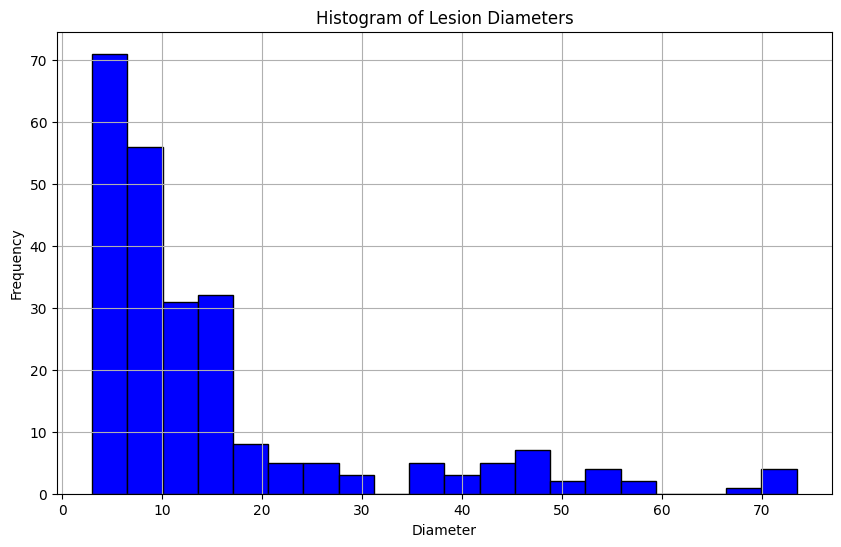

Max box size to include the largest lesion: {'X': 46, 'Y': 53, 'Z': 37}
Size of the minimal box to include even the biggest lesion: {'X': 192, 'Y': 219, 'Z': 156}


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate the diameters
df_info['Diameter'] = np.sqrt((df_info['Max X'] - df_info['Min X'])**2 + 
                              (df_info['Max Y'] - df_info['Min Y'])**2 + 
                              (df_info['Max Z'] - df_info['Min Z'])**2)

# Compute statistics
diameter_stats = df_info['Diameter'].describe()

# Print the statistics
print(diameter_stats)

# Plot a histogram of the diameters
plt.figure(figsize=(10, 6))
plt.hist(df_info['Diameter'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Lesion Diameters')
plt.xlabel('Diameter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Determine the size of the minimal box
# Calculate the box size for each lesion
df_info['Box X'] = df_info['Max X'] - df_info['Min X']
df_info['Box Y'] = df_info['Max Y'] - df_info['Min Y']
df_info['Box Z'] = df_info['Max Z'] - df_info['Min Z']

# Find the maximum box size needed in each dimension
max_box_size = {
    'X': df_info['Box X'].max(),
    'Y': df_info['Box Y'].max(),
    'Z': df_info['Box Z'].max(),
}

print(f"Max box size to include the largest lesion: {max_box_size}")




In [10]:
#diameter of 64x64x64 box is 111 which is much larger than the diameter of the biggest lesion
np.sqrt(64**2 + 64**2 + 64**2)

110.85125168440814

In [2]:
# The volume of 64d box is ~3 times larger than the volume biggest lesion theorethical box
64**3/(53*46*37)

2.9060594638937545

In [4]:
df_info.to_csv("df_info.csv")

Crop to 64x64x64 box around the center of the lesion

In [30]:
import nibabel as nib
import numpy as np
import os

# Assuming df_info is the DataFrame with the following columns: 'Filename', 'Actual Center X', 'Actual Center Y', 'Actual Center Z'
# Also assuming that the MRI, RTDOSE, and RTSTRUCT files have the same filenames in their respective directories.

def load_nii(file_path):
    """Load a NIfTI file and return the data array."""
    nii = nib.load(file_path)
    return nii.get_fdata(), nii.affine

def crop_around_center(image_data, center, crop_size=64):
    """Crop a 3D volume around the specified center."""
    start = np.array(center) - crop_size // 2
    end = start + crop_size 
    cropped_image = image_data[start[0]:end[0], start[1]:end[1], start[2]:end[2]]
    return cropped_image

def save_cropped_image(cropped_image, affine, output_path):
    """Save the cropped image as a new NIfTI file."""
    cropped_img_nii = nib.Nifti1Image(cropped_image, affine)
    nib.save(cropped_img_nii, output_path)

# Directories for MRI, RTDOSE, and RTSTRUCT images
input_path = '../images_nii/ppp_nii'
output_path = '../images_nii/64x64x64'
crop_size = 64

# Iterate over the rows of the DataFrame and perform the cropping
for index, row in df_info.iterrows():
    struct_filename = row['Filename']
    center = [row['BB Center X'], row['BB Center Y'], row['BB Center Z']]
    modality,pid,course = struct_filename.split('$',1)[0][:-1].split('_')
    lesion = struct_filename.split('$')[1]
    mri_data, mri_affine = load_nii(os.path.join(input_path,f"mri_{pid}_{course}.nii"))

    #Crop RTSTRUCT
    struct_data, struct_affine = load_nii(os.path.join(input_path, struct_filename))
    cropped_struct = crop_around_center(struct_data, center, crop_size)
    save_cropped_image(cropped_struct, mri_affine, os.path.join(output_path, struct_filename))
        
    #Crop MRI
    mri_filename = 'mri_' + struct_filename.split('_',1)[1]
    mri_data, mri_affine = load_nii(os.path.join(input_path,f"mri_{pid}_{course}.nii"))
    cropped_mri = crop_around_center(mri_data, center, crop_size)
    save_cropped_image(cropped_mri, mri_affine, os.path.join(output_path, mri_filename))
        
    #Crop RTDOSE
    dose_filename = 'dose_' + struct_filename.split('_',1)[1]
    dose_data, dose_affine = load_nii(os.path.join(input_path, f"dos_{pid}_{course}.nii"))
    cropped_dose = crop_around_center(dose_data, center, crop_size)
    save_cropped_image(cropped_dose, mri_affine, os.path.join(output_path, dose_filename))
